In [1]:
import matplotlib.pyplot as matplot
from collections import defaultdict
from scipy.sparse import csr_matrix, find
import numpy as np
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
import pylab

In [2]:
#For reading the csr
def csr_read(fname, ftype="csr", nidx=1):
    r""" 
        Read CSR matrix from a text file. 
        
        \param fname File name for CSR/CLU matrix
        \param ftype Input format. Acceptable formats are:
            - csr - Compressed sparse row
            - clu - Cluto format, i.e., CSR + header row with "nrows ncols nnz"
        \param nidx Indexing type in CSR file. What does numbering of feature IDs start with?
    """
    
    with open(fname) as f:
        lines = f.readlines()
    
    if ftype == "clu":
        p = lines[0].split()
        nrows = int(p[0])
        ncols = int(p[1])
        nnz = long(p[2])
        lines = lines[1:]
        assert(len(lines) == nrows)
    elif ftype == "csr":
        nrows = len(lines)
        ncols = 0 
        nnz = 0 
        for i in xrange(nrows):
            p = lines[i].split()
            if len(p) % 2 != 0:
                raise ValueError("Invalid CSR matrix. Row %d contains %d numbers." % (i, len(p)))
            nnz += len(p)/2
            for j in xrange(0, len(p), 2): 
                cid = int(p[j]) - nidx
                if cid+1 > ncols:
                    ncols = cid+1
    else:
        raise ValueError("Invalid sparse matrix ftype '%s'." % ftype)
    val = np.zeros(nnz, dtype=np.float)
    ind = np.zeros(nnz, dtype=np.int)
    ptr = np.zeros(nrows+1, dtype=np.long)
    n = 0 
    for i in xrange(nrows):
        p = lines[i].split()
        for j in xrange(0, len(p), 2): 
            ind[n] = int(p[j]) - nidx
            val[n] = float(p[j+1])
            n += 1
        ptr[i+1] = n 
    
    assert(n == nnz)
    
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.float)
    mat.sort_indices()
    return mat

In [3]:
#Function Declaration for finding the mmean

def cal_mean(mat, indx, k):
   
    temp = 1
    cntr_list = []  
    for i in range(1, k+1):
        indx_mat = [j for j, x in enumerate(indx) if x == i]
        values_mat = mat[indx_mat,:]
        if (values_mat.shape[0] > temp):
            cntr_list.append(values_mat.toarray().mean(0))
    csr_cntr = csr_matrix(cntr_list)
    
    return csr_cntr

In [4]:
def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = float(1.0/np.sqrt(rsum))
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat

In [5]:
#Function declaration for calculating similar points
def calculate(mat, centroids):

    indx = []
    csr_similarity = mat.dot(centroids.T)
  
    for x in range(csr_similarity.shape[0]):
        number_r = csr_similarity.getrow(x).toarray()[0].ravel()
        sorted_ind = number_r.argsort()[-1]
        indx.append(sorted_ind + 1)
    return indx  

In [6]:
file_name = "train.dat"
mat = csr_read(file_name, ftype="csr", nidx=1)
mat2 = csr_idf(mat, copy=True)
mat3 = csr_l2normalize(mat2, copy=True)

In [7]:
# Function declaration for Kmeans clustering
def Clustering_KMeans(k, mat, iteration_count):

    shuffle_set = shuffle(mat, random_state=0)
    cntrd = shuffle_set[:k,:]

    for q in range(iteration_count): 
        idx = calculate(mat, cntrd)            
        cntrd = cal_mean(mat, idx, k)        
    
    return idx

In [8]:
# Declaring the function for the Bisecting Kmeans clustering
def Clustering_BKMeans(matrix, num_k):
    start_cluster, ind_clust = [],[]
    start_cluster.append(matrix)
    for i in range(matrix.shape[0]):   
        ind_clust.append(1)
    number = 1
    count = 1
    for q in range(1, 7):      
        cnt_indx, lst, ls_inp = [], [], []
        e = len(ind_clust)
        w = q + 1
        
        for r in range(w):  
            lst.append(0)
        
        for r in range(k): 
            num_check = ind_clust[r]
            if(num_check == number):              
                ls_inp.append(matrix[r,:].toarray()[0])
                cnt_indx.append(r)
            if(num_check > number):
                 ind_clust[r] = ind_clust[r]+1
        cnvt_toscr_input = csr_matrix(ls_inp)       
        output_kmeans = Clustering_KMeans(7,cnvt_toscr_input, 20)
        
        for cntr1 in range(k):
            check_bisect = output_kmeans[cntr1]
            if(check_bisect == 2):               
                ind_clust[cnt_indx[cntr1]] = number + 1        
            
        for cnt in range(k):   
            ind_clust = ind_clust[cnt] - 1;
            lst[ind_clust] = lst[ind_clust] + 1
        
        num_high = lst[0]
        
        for t in range(1, w):
            if (lst[t] > num_high):             
                count = t + 1
        
    return ind_clust 

In [9]:
# Decalring two lists to save the values of k and the calinski score
x,y = [], []

# Calling in the bisecting k means with required k values
for k in range(3, 22, 2):
    output_Bisecting_KMeans = Clustering_KMeans(k, mat3, 10)
    calinski_score = calinski_harabaz_score(mat3.toarray(), output_Bisecting_KMeans)
    x.append(k)
    print "Value of k : " + str(k) 
    y.append(score)
    print "The calinski harabaz score is : " + str(calinski_score)
   

Value of k : 3
The calinski harabaz score is : 64.9167797232
Value of k : 5
The calinski harabaz score is : 51.5520235547
Value of k : 7
The calinski harabaz score is : 49.6038587251
Value of k : 9
The calinski harabaz score is : 45.1129268033
Value of k : 11
The calinski harabaz score is : 40.4352081289
Value of k : 13
The calinski harabaz score is : 37.711910979
Value of k : 15
The calinski harabaz score is : 35.6842231128
Value of k : 17
The calinski harabaz score is : 34.2240350136
Value of k : 19
The calinski harabaz score is : 34.165354354
Value of k : 21
The calinski harabaz score is : 32.8168006133


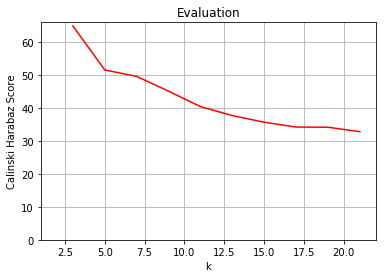

In [11]:
#Plotting Here the graph

fig,ax = matplot.subplots()
ax.grid(True)
matplot.xlabel('k')
matplot.ylabel('Calinski Harabaz Score')
matplot.title('Evaluation')
matplot.axis([1, 22, 0, 66])
matplot.plot(x, y, 'red')
pylab.show()


In [13]:
# Finally Write the output to the file output.dat

output = open("output.dat", "w")
for value in output_Bisecting_KMeans:
    output.write(str(value) +'\n')
output.close()